In [ ]:
!pip install -qq transformers


In [1]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


In [2]:

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [13]:
# set working directory -> you must set the path into which you have uploaded the data file
# this is required in the case of colab
#%cd /content/drive/My\ Drive/DMTM/Research Project
%ls

 Volume in drive C has no label.
 Volume Serial Number is 2E3C-EA4F

 Directory of C:\Users\benza-ord\source\repos\CS583-Research-Project

12/02/2020  09:03 AM    <DIR>          .
12/02/2020  09:03 AM    <DIR>          ..
12/02/2020  12:00 AM    <DIR>          .ipynb_checkpoints
12/01/2020  07:33 AM    <DIR>          .vscode
12/02/2020  03:55 AM           190,248 Bert_sentiment_analysis.ipynb
11/28/2020  08:24 AM         3,675,260 cxs583_cleaned_file_v2.csv
12/02/2020  09:03 AM           605,871 cxs583_TESTDATA_OBAMA_cleaned.csv
12/02/2020  09:03 AM           565,322 cxs583_TESTDATA_ROMNEY_cleaned.csv
11/29/2020  07:36 AM            17,169 DataPre_processing.ipynb
11/29/2020  07:36 AM            35,823 LICENSE
12/01/2020  11:46 PM             6,396 LSTM.ipynb
12/01/2020  07:33 AM             9,225 ML_models.ipynb
12/02/2020  02:38 AM    <DIR>          models
12/02/2020  02:29 AM             9,520 obama.txt
12/02/2020  03:55 AM             4,656 obama_bert.txt
12/02/2020  08:43 AM      

In [3]:
df = pd.read_csv("cxs583_cleaned_file_v2.csv")
df.head()

,date,time,tweet,class,result,tweet_length,tweet_cleaned,tweet_clst
0,2012-10-16 00:00:00,10:28:53-05:00,"Kirkpatrick, who wore a baseball cap embroider...",0,NaN,136,"['Kirkpatrick', 'wear', 'baseball', 'cap', 'em...",Kirkpatrick who wore a baseball cap embroidere...
1,2012-10-16 00:00:00,10:04:30-05:00,#<e>obama</e> debates that Cracker Ass Cracker...,1,NaN,88,"['obama', 'debate', 'Cracker', 'Ass', 'Cracker...",obama debates that Cracker Ass Cracker tonight...
2,2012-10-16 00:00:00,09:50:08-05:00,@Hollivan @hereistheanswer Youre missing the ...,0,NaN,140,"['Hollivan', 'hereistheanswer', 'Youre', 'miss...",Hollivan hereistheanswer Youre missing the poi...
3,2012-10-16 00:00:00,10:00:16-05:00,I was raised as a Democrat left the party yea...,-1,NaN,146,"['raise', 'Democrat', 'leave', 'party', 'years...",I was raised as a Democrat left the party year...
4,2012-10-16 00:00:00,09:48:07-05:00,The <e>Obama camp</e> can't afford to lower ex...,0,NaN,124,"['Obama', 'camp', 'ca', 'afford', 'lower', 'ex...",The Obama camp ca n't afford to lower expectat...


In [4]:
df.shape

(11273, 8)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\benza-ord\anaconda3\envs\keras-gpu\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


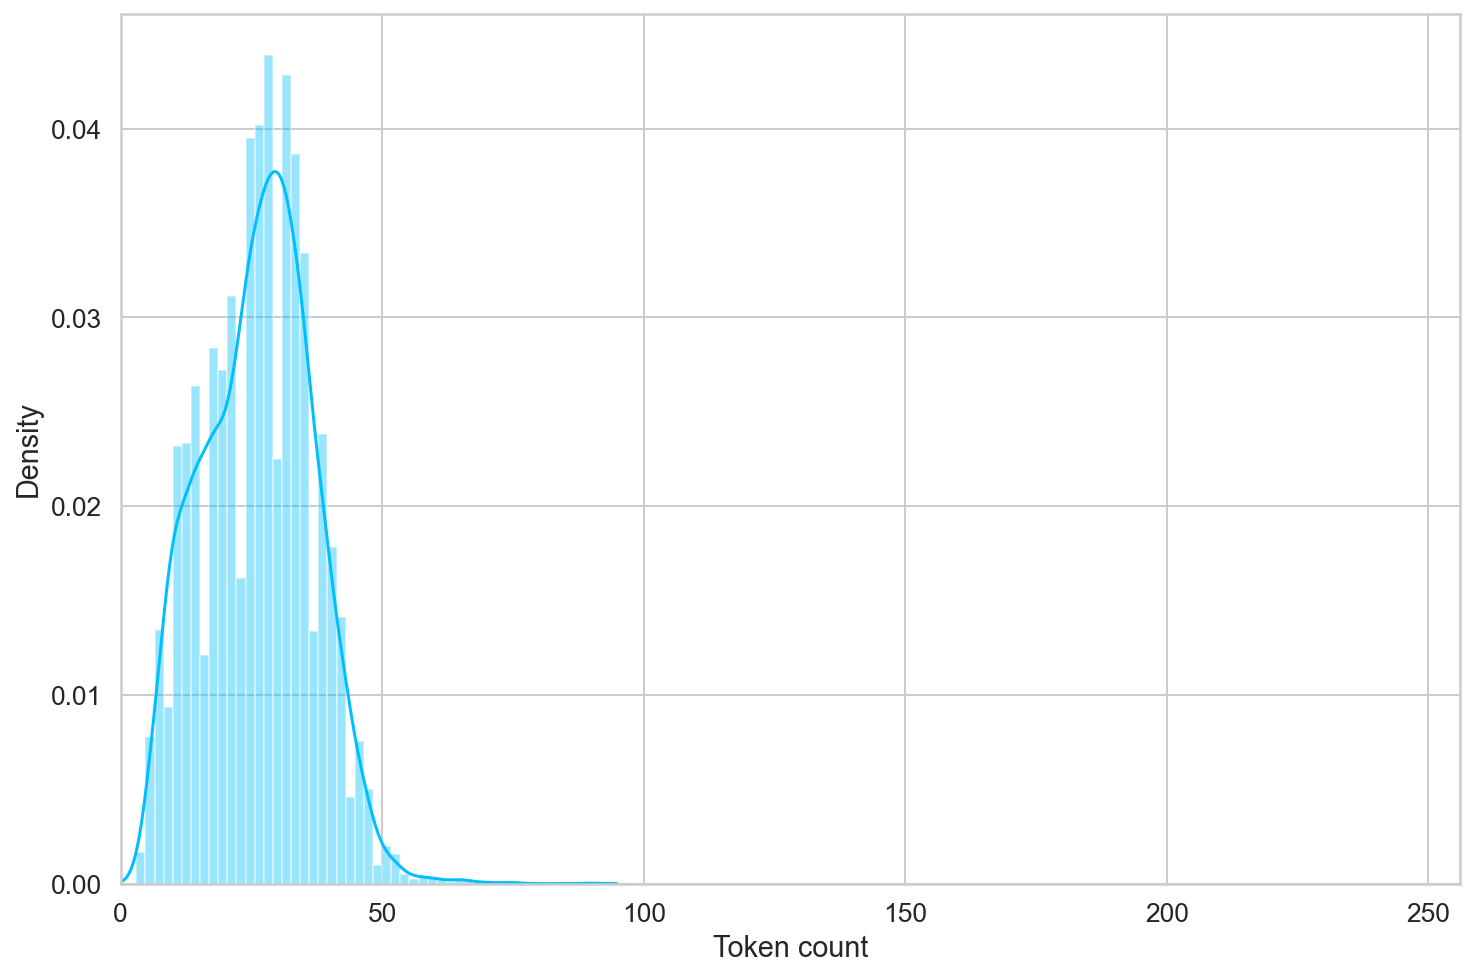

In [4]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

token_lens = []

def convert_sentiment_score(y):
  y = int(y)
  return y+1

df['sentiment'] = df['class'].apply(convert_sentiment_score)

df['tweet_clst'] = df['tweet_clst'].astype(str)

for txt in df['tweet_clst']:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [6]:
df.head()

,date,time,tweet,class,result,tweet_length,tweet_cleaned,tweet_clst,sentiment
0,2012-10-16 00:00:00,10:28:53-05:00,"Kirkpatrick, who wore a baseball cap embroider...",0,NaN,136,"['Kirkpatrick', 'wear', 'baseball', 'cap', 'em...",Kirkpatrick who wore a baseball cap embroidere...,1
1,2012-10-16 00:00:00,10:04:30-05:00,#<e>obama</e> debates that Cracker Ass Cracker...,1,NaN,88,"['obama', 'debate', 'Cracker', 'Ass', 'Cracker...",obama debates that Cracker Ass Cracker tonight...,2
2,2012-10-16 00:00:00,09:50:08-05:00,@Hollivan @hereistheanswer Youre missing the ...,0,NaN,140,"['Hollivan', 'hereistheanswer', 'Youre', 'miss...",Hollivan hereistheanswer Youre missing the poi...,1
3,2012-10-16 00:00:00,10:00:16-05:00,I was raised as a Democrat left the party yea...,-1,NaN,146,"['raise', 'Democrat', 'leave', 'party', 'years...",I was raised as a Democrat left the party year...,0
4,2012-10-16 00:00:00,09:48:07-05:00,The <e>Obama camp</e> can't afford to lower ex...,0,NaN,124,"['Obama', 'camp', 'ca', 'afford', 'lower', 'ex...",The Obama camp ca n't afford to lower expectat...,1


In [5]:
# most of the tweets do not have more than 50 chars
MAX_LEN = 75

# split 90-10 train-test
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
# split test into 50-50 val-test
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [7]:
df_train.shape, df_val.shape, df_test.shape

((10145, 9), (564, 9), (564, 9))

In [27]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [28]:
# create a couple of data loaders
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df['tweet_clst'].to_numpy(),
    targets=df['sentiment'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size
  )

In [8]:
BATCH_SIZE = 10

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [14]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [15]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'])

torch.Size([10, 75])
torch.Size([10, 75])
tensor([2, 1, 2, 0, 1, 1, 0, 0, 1, 1])


In [9]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [10]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

class_names = [0, 1, 2]
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [18]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [19]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  #for d in data_loader:
  for batch_idx, d in enumerate(data_loader):
    if (batch_idx % 100 == 0):
        print('BATCH ',batch_idx, len(data_loader))
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [20]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [21]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
  
    train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model, 'best_model.pt')
        best_accuracy = val_acc

Epoch 1/10
----------
BATCH  0 1015
BATCH  100 1015
BATCH  200 1015
BATCH  300 1015
BATCH  400 1015
BATCH  500 1015
BATCH  600 1015
BATCH  700 1015
BATCH  800 1015
BATCH  900 1015
BATCH  1000 1015
Train loss 0.9727434067596943 accuracy 0.5299162148841794
Val   loss 0.8897199202002141 accuracy 0.6063829787234042

Epoch 2/10
----------
BATCH  0 1015
BATCH  100 1015
BATCH  200 1015
BATCH  300 1015
BATCH  400 1015
BATCH  500 1015
BATCH  600 1015
BATCH  700 1015
BATCH  800 1015
BATCH  900 1015
BATCH  1000 1015
Train loss 0.7173258544923049 accuracy 0.7035978314440612
Val   loss 0.9487657912990504 accuracy 0.6347517730496454

Epoch 3/10
----------
BATCH  0 1015
BATCH  100 1015
BATCH  200 1015
BATCH  300 1015
BATCH  400 1015
BATCH  500 1015
BATCH  600 1015
BATCH  700 1015
BATCH  800 1015
BATCH  900 1015
BATCH  1000 1015
Train loss 0.5024588523276627 accuracy 0.8225726959093149
Val   loss 1.2228287688472814 accuracy 0.625886524822695

Epoch 4/10
----------
BATCH  0 1015
BATCH  100 1015
BATCH  

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [22]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.6790780141843972

In [29]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [14]:

model = torch.load('best_model.pt')

In [15]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

C:\Users\benza-ord\anaconda3\envs\keras-gpu\lib\site-packages\transformers\tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [16]:
df_test_obama = pd.read_csv("cxs583_TESTDATA_OBAMA_cleaned.csv")
df_test_obama.head()

,id,tweet,tweet_length,tweet_cleaned,tweet_clst
0,1,<e>Obama</e> has to maintain his professionali...,106,"['Obama', 'maintain', 'professionalism', 'thro...",Obama has to maintain his professionalism thro...
1,2,<e>Obama</e> went into the debate swinging and...,101,"['Obama', 'go', 'debate', 'swing', 'come', 'ba...",Obama went into the debate swinging and came o...
2,3,Ditto. I started @247LS 4 years ago. RT @bmorr...,146,"['Ditto', 'start', 'years', 'ago', 'RT', 'bmor...",Ditto I started 247LS 4 years ago RT bmorrisse...
3,4,I absolutely love <e>Obama</e>'s view in <a>im...,125,"['absolutely', 'love', 'Obama', 'view', 'immig...",I absolutely love Obama 's view in immigration...
4,5,I'm agreeing completely with <e>Obama</e>'s st...,132,"['agree', 'completely', 'Obama', 'stance', 'im...",I 'm agreeing completely with Obama 's stance ...


In [17]:
df_test_romney = pd.read_csv("cxs583_TESTDATA_ROMNEY_cleaned.csv")
df_test_romney.head()

,id,tweet,tweet_length,tweet_cleaned,tweet_clst
0,1,<e>Romney</e> got 3 less minutes and had to de...,103,"['Romney', 'get', 'less', 'minutes', 'debate',...",Romney got 3 less minutes and had to debate Ca...
1,2,<e>Mitt </e>is beating him UP! on his record...,79,"['Mitt', 'beat', 'record', 'credibility', 'cha...",Mitt is beating him UP on his record on credib...
2,3,I actually like <e>Romney </e>'s response to ...,58,"['actually', 'like', 'Romney', 'response', 'im...",I actually like Romney 's response to immigration
3,4,Just for that <a>immigration statement </a>tha...,115,"['immigration', 'statement', 'Romney', 'answer...",Just for that immigration statement that Romne...
4,5,This man <e>Romney </e>is tearing this dude ...,68,"['man', 'Romney', 'tear', 'dude', 'economics']",This man Romney is tearing this dude up on eco...


In [32]:
df_test_romney.head()

,id,tweet,tweet_length,tweet_cleaned,tweet_clst,sentiment
0,1,<e>Romney</e> got 3 less minutes and had to de...,103,"['Romney', 'get', 'less', 'minutes', 'debate',...",Romney got 3 less minutes and had to debate Ca...,0
1,2,<e>Mitt </e>is beating him UP! on his record...,79,"['Mitt', 'beat', 'record', 'credibility', 'cha...",Mitt is beating him UP on his record on credib...,0
2,3,I actually like <e>Romney </e>'s response to ...,58,"['actually', 'like', 'Romney', 'response', 'im...",I actually like Romney 's response to immigration,0
3,4,Just for that <a>immigration statement </a>tha...,115,"['immigration', 'statement', 'Romney', 'answer...",Just for that immigration statement that Romne...,0
4,5,This man <e>Romney </e>is tearing this dude ...,68,"['man', 'Romney', 'tear', 'dude', 'economics']",This man Romney is tearing this dude up on eco...,0


In [31]:
df_test_romney['tweet_clst'] = df_test_romney['tweet_clst'].astype(str)
df_test_obama['tweet_clst'] = df_test_obama['tweet_clst'].astype(str)

df_test_romney['sentiment'] = 0
df_test_obama['sentiment'] = 0

In [33]:
obama_test_data_loader = create_data_loader(df_test_obama, tokenizer, MAX_LEN, BATCH_SIZE)
yo_review_texts, yo_pred, yo_pred_probs, yo_test = get_predictions(
  model,
  obama_test_data_loader
)

C:\Users\benza-ord\anaconda3\envs\keras-gpu\lib\site-packages\transformers\tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [34]:
romney_test_data_loader = create_data_loader(df_test_romney, tokenizer, MAX_LEN, BATCH_SIZE)
yr_review_texts, yr_pred, yr_pred_probs, yr_test = get_predictions(
  model,
  romney_test_data_loader
)

In [17]:
print(classification_report(y_test, y_pred, target_names=["Negative", "Neutral", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.69      0.77      0.73       223
     Neutral       0.65      0.65      0.65       183
    Positive       0.75      0.62      0.68       158

    accuracy                           0.69       564
   macro avg       0.70      0.68      0.69       564
weighted avg       0.69      0.69      0.69       564



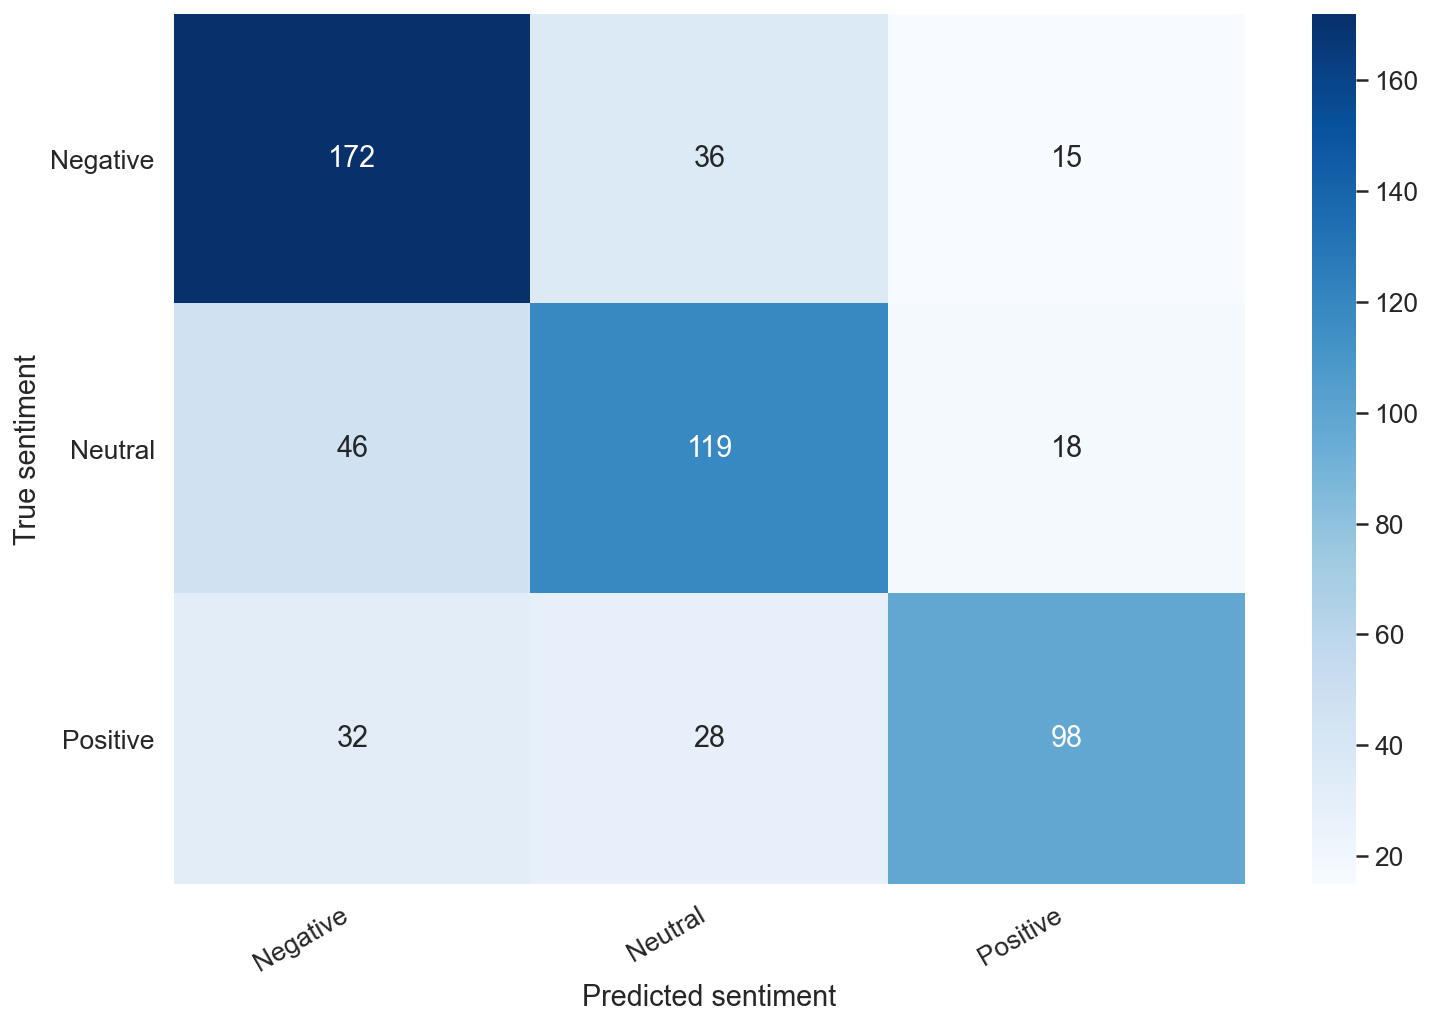

In [18]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=["Negative", "Neutral", "Positive"], columns=["Negative", "Neutral", "Positive"])
show_confusion_matrix(df_cm)

In [21]:
y_pred

tensor([0, 0, 0, 2, 1, 1, 0, 0, 2, 1, 2, 1, 2, 1, 2, 1, 0, 0, 0, 0, 1, 1, 0, 1,
        0, 1, 0, 2, 2, 1, 1, 1, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 1, 0, 0, 2,
        1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 2, 1, 1, 0, 2, 1, 0, 0, 2, 2, 0, 1, 0,
        2, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 0, 1, 1, 2, 0, 1, 0, 1, 0, 0, 2, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0, 0, 1, 1, 2, 0, 0, 2, 1, 1,
        0, 2, 0, 2, 2, 0, 2, 2, 1, 1, 0, 0, 0, 2, 1, 2, 1, 1, 1, 0, 0, 2, 1, 2,
        0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1, 0, 2, 1, 2, 0, 2,
        0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 1, 0, 2, 0, 0, 0, 0,
        0, 0, 0, 0, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 0, 1, 2, 1, 2, 0, 0,
        1, 1, 0, 0, 1, 0, 0, 1, 1, 2, 0, 0, 0, 1, 2, 2, 0, 2, 0, 1, 1, 0, 0, 0,
        0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 1, 1, 2, 1, 0, 2, 0, 2, 1, 0, 0, 1, 2,
        0, 2, 1, 0, 0, 0, 0, 1, 0, 2, 1, 1, 2, 2, 2, 1, 2, 2, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 2, 0, 1, 1, 1, 0, 2, 2,

In [22]:
y_pred - 1

tensor([-1, -1, -1,  1,  0,  0, -1, -1,  1,  0,  1,  0,  1,  0,  1,  0, -1, -1,
        -1, -1,  0,  0, -1,  0, -1,  0, -1,  1,  1,  0,  0,  0, -1,  1, -1,  1,
        -1,  1, -1,  1, -1, -1, -1, -1,  0, -1, -1,  1,  0, -1,  0, -1, -1, -1,
        -1,  0, -1, -1, -1,  1,  0,  0, -1,  1,  0, -1, -1,  1,  1, -1,  0, -1,
         1,  0,  0,  1,  0,  1, -1, -1, -1,  0, -1, -1, -1,  0,  0,  1, -1,  0,
        -1,  0, -1, -1,  1, -1, -1, -1, -1,  0,  0, -1, -1, -1,  0, -1, -1,  1,
        -1,  0, -1, -1,  0,  0,  1, -1, -1,  1,  0,  0, -1,  1, -1,  1,  1, -1,
         1,  1,  0,  0, -1, -1, -1,  1,  0,  1,  0,  0,  0, -1, -1,  1,  0,  1,
        -1, -1,  1, -1,  1, -1, -1, -1, -1, -1, -1,  1,  1, -1, -1, -1, -1,  0,
        -1,  1,  0,  1, -1,  1, -1,  0,  1,  0, -1, -1, -1, -1, -1, -1,  1, -1,
         1,  1,  1, -1,  1,  0, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  0,
         0,  0,  0,  1,  0,  0,  0,  1,  1,  0,  1, -1,  0,  1,  0,  1, -1, -1,
         0,  0, -1, -1,  0, -1, -1,  0, 

In [25]:
outF = open("obama_bert.txt", "w")
STUDENT_ID= 15
# PRINT STUDENT ID 
outF.write(str(STUDENT_ID))
outF.write("\n")

for idx, pred in zip(range(len(y_pred)), y_pred):
  # write line to output file
    outF.write(str(idx)+";;"+str(pred.item()-1))
    outF.write("\n")
outF.close()

In [37]:
outF = open("obama.txt", "w")
STUDENT_ID= 15
# PRINT STUDENT ID 
outF.write(str(STUDENT_ID))
outF.write("\n")

for idx, pred in zip(range(len(yo_pred)), yo_pred):
  # write line to output file
    outF.write(str(idx+1)+";;"+str(pred.item()-1))
    outF.write("\n")
outF.close()

In [38]:
outF = open("romney.txt", "w")
STUDENT_ID= 15
# PRINT STUDENT ID 
outF.write(str(STUDENT_ID))
outF.write("\n")

for idx, pred in zip(range(len(yr_pred)), yr_pred):
  # write line to output file
    outF.write(str(idx+1)+";;"+str(pred.item()-1))
    outF.write("\n")
outF.close()